In [8]:
# disable warnings
import warnings
warnings.filterwarnings("ignore")

# basic imports
import os
import numpy as np
import datetime
import tensorflow as tf 
import tensorflow_addons as tfa
from functools import partial

from keras.utils import dataset_utils
import matplotlib.pyplot as plt

import baseline_config
import echo_tfimm_model

In [9]:
DATA_PIPELINE_SHUFFLE_SIZE = 500
DATA_PIPELINE_MAX_SIZE     = 500

In [10]:
def paths_and_labels_to_dataset(image_paths,labels,num_classes):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    img_ds = path_ds.map(
        lambda path: tf.io.read_file(path), 
        num_parallel_calls=tf.data.AUTOTUNE
    )
    label_ds = dataset_utils.labels_to_dataset(
        labels, 
        'categorical', 
        num_classes)
    img_ds = tf.data.Dataset.zip((img_ds, label_ds))
    return img_ds

def create_dataset(subset):
    image_paths, labels, class_names = dataset_utils.index_directory(
            baseline_config.dataset_path + subset,
            labels="inferred",
            formats=('.pt'),
            class_names=None,
            shuffle=False,
            seed=42,
            follow_links=False)

    dataset = paths_and_labels_to_dataset(
        image_paths=image_paths,
        labels=labels,
        num_classes=len(class_names))
    
    return dataset, class_names

train_dataset, class_names = create_dataset('TRAIN/')
test_dataset, _            = create_dataset('TEST/')
validation_dataset, _      = create_dataset('VALIDATION/')
print("class names: ", class_names)

Found 3606 files belonging to 15 classes.
Found 22 files belonging to 15 classes.
Found 284 files belonging to 15 classes.
class names:  ['Aegotheles cristatus owlet-nightjar', 'Alauda arvensis European Skylark', 'Caligavis chrysops Yellow-faced honeyeater', 'Capra hircus Feral goat', 'Cervus unicolour Sambar deer', 'Colluricincla harmonica Grey shrikethrush', 'Corvus coronoides Australian raven', 'Dama dama Fallow Deer', 'Eopsaltria australis Eastern yellow robin', 'Felis Catus Cat', 'Pachycephala rufiventris Rufous whistler', 'Ptilotula penicillata White-plumed honeyeater', 'Rattus norvegicus Brown rat', 'Strepera graculina Pied currawong', 'sus scrofa Wild pig']


In [11]:
def dataset_transforms(image,label):
  
    # reshape into standard 3 channels
    image = tf.io.parse_tensor(image, tf.float32)
    image = tf.expand_dims(image, -1)
    
    image = tf.ensure_shape(image, [216, 128, 1])
    image = tf.image.resize(image, 
                            (echo_tfimm_model.MODEL_INPUT_IMAGE_HEIGHT, 
                             echo_tfimm_model.MODEL_INPUT_IMAGE_WIDTH), 
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    # rescale to range [0,1]
    image = image - tf.reduce_min(image) 
    image = image / (tf.reduce_max(image)+tf.keras.backend.epsilon()) 
    
    return image,label

In [12]:
# sample the classes evenly
def make_sampled_dataset(dataset):
    class_name_map = {}
    for index, class_name in enumerate(class_names):
        class_name_map[class_name] = index
    target_distribution = np.full(len(class_names), 1.0 / len(class_names))

    dataset_classes = [dataset.filter(lambda x,y: tf.argmax(y) == class_index).shuffle(DATA_PIPELINE_SHUFFLE_SIZE).repeat() for class_index in range(len(class_names))]
    sampled_dataset = tf.data.Dataset.sample_from_datasets(dataset_classes, weights=target_distribution)
    return sampled_dataset

# train_dataset = make_sampled_dataset(train_dataset)
# validation_dataset = make_sampled_dataset(validation_dataset)
# test_dataset = make_sampled_dataset(test_dataset)

In [13]:
def test_sampling(dataset):
  bucket_counts = np.zeros(len(class_names))
  for img,label in dataset.take(100):
    bucket_counts[tf.argmax(label).numpy()] += 1
  print("sample counts :", bucket_counts,
        "final dist    :", bucket_counts / np.sum(bucket_counts))
  
# test_sampling(test_dataset)

In [14]:
# create all the data pipelines
train_dataset_b = ( 
                  train_dataset  
                  .shuffle(5000)     
                  .map(dataset_transforms)
                  #.take(DATA_PIPELINE_MAX_SIZE)
                  .cache()               
                  .batch(baseline_config.batch_size)
                  .repeat()
)

validation_dataset_b = ( 
                  validation_dataset
                  .shuffle(5000) 
                  .map(dataset_transforms)
                  #.take(DATA_PIPELINE_MAX_SIZE)
                  .cache()                     
                  .batch(baseline_config.batch_size)
                  .repeat()
)

test_dataset_b = ( 
                  test_dataset
                  .shuffle(5000) 
                  .map(dataset_transforms)
                  #.take(DATA_PIPELINE_MAX_SIZE)
                  .cache()                   
                  .batch(baseline_config.batch_size)
                  .repeat()
)

In [15]:
# these functions will speed up running the notebook if you are investigation different model types
def save_cache_datasets():
    # generate cached training dataset
    tf.data.Dataset.save(train_dataset_b, 'datasets/train', compression='GZIP', shard_func=None, checkpoint_args=None)
    # generate cached validation dataset
    tf.data.Dataset.save(validation_dataset_b, 'datasets/validation', compression='GZIP', shard_func=None, checkpoint_args=None)
    # generate cached test dataset
    tf.data.Dataset.save(test_dataset_b, 'datasets/test', compression='GZIP', shard_func=None, checkpoint_args=None)

# these functions will speed up running the notebook if you are investigation different model types    
def load_cache_dataset():
    train_dataset_b = tf.data.Dataset.load('datasets/train', compression='GZIP').cache().repeat()
    validation_dataset_b = tf.data.Dataset.load('datasets/validation', compression='GZIP').cache().repeat()
    test_dataset_b = tf.data.Dataset.load('datasets/test', compression='GZIP').cache().repeat()    

(8, 224, 224, 1) (8, 15)
0.0 1.0
(8, 224, 224, 1) (8, 15)
0.0 1.0
(8, 224, 224, 1) (8, 15)
0.0 1.0


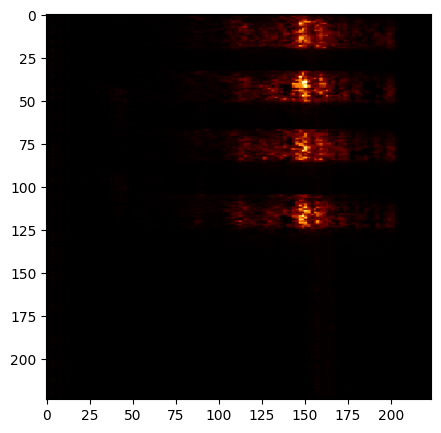

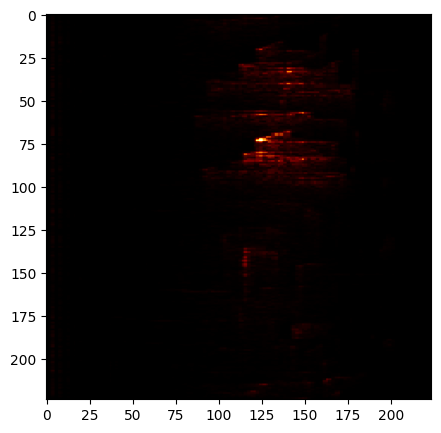

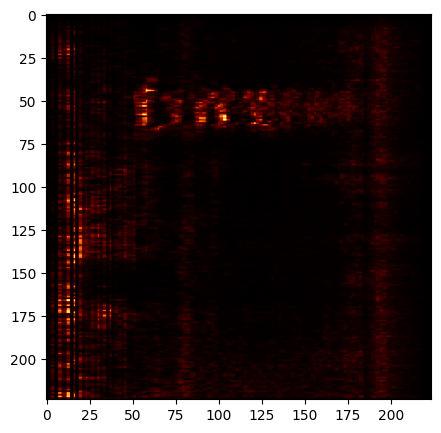

In [16]:
for item,lbl in train_dataset_b.take(3):
    print(item.shape, lbl.shape)
    print(np.min(item), np.max(item))
    plt.figure(figsize=(5,5))
    plt.imshow(item[0,:,:,0], cmap='afmhot')

In [17]:
# uncomment to list all possible timm models
tfimm.list_models()

['cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 '

In [18]:
# construct the model
model = echo_tfimm_model.EchoTfimmModel()
model.fm.trainable = False
model.build([None, 
             echo_tfimm_model.MODEL_INPUT_IMAGE_HEIGHT, 
             echo_tfimm_model.MODEL_INPUT_IMAGE_WIDTH, 
             echo_tfimm_model.MODEL_INPUT_IMAGE_CHANNELS])

All PyTorch model weights were used when initializing EfficientNet.
All the weights of EfficientNet were initialized from the PyTorch model.



In [19]:
if not os.path.exists('models/'):
    os.mkdir('models/')
    
# the form_logits means the loss function has the 'softmax' buillt in.  This approach is numerically more stable
# than including the softmax activation on the last layer of the classifier
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing = 0.0), 
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), 
              metrics=["accuracy"],
              )

# tensorboard for visualisation of results
log_dir = "tensorboard_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)

# reduce learning rate to avoid overshooting local minima
lr_reduce_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                      factor=0.6,
                                                      patience=4, 
                                                      verbose=1,
                                                      mode='max',
                                                      cooldown=0, 
                                                      min_lr=1e-7)

# end the training if no improvement for 8 epochs in a row, then restore best model weights
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=16,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

# save the best model as it trains..
mcp_save = tf.keras.callbacks.ModelCheckpoint('models/checkpoint_timm_model.hdf5', 
                                            save_weights_only=True,
                                           save_best_only=True, 
                                           monitor='val_loss', 
                                           mode='min')

# fit the model to the training set
history = model.fit(train_dataset_b, 
          steps_per_epoch=1000,
          validation_steps=25,
          validation_data=validation_dataset_b,
          callbacks=[lr_reduce_plateau, early_stopping, tensorboard_callback, mcp_save],
          epochs=2)

classifier_weights = model.classifier.get_weights()

Epoch 1/2
1000/1000 [==============================] - 45s 36ms/step - loss: 2.9960 - accuracy: 0.4351 - val_loss: 2.2505 - val_accuracy: 0.4700 - lr: 1.0000e-04
Epoch 2/2
1000/1000 [==============================] - 33s 33ms/step - loss: 1.2963 - accuracy: 0.7272 - val_loss: 2.2223 - val_accuracy: 0.5150 - lr: 1.0000e-04


In [20]:
# construct the model
model.fm.trainable = True
model.trainable=True

# the form_logits means the loss function has the 'softmax' buillt in.  This approach is numerically more stable
# than including the softmax activation on the last layer of the classifier
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing = 0.0), 
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-7), 
              metrics=["accuracy"],
              )

# applying the idea of fine tuning, start training from a pre-trained classifier
model.classifier.set_weights(classifier_weights)

# fit the model to the training set
history = model.fit(train_dataset_b, 
          steps_per_epoch=500,
          validation_steps=50,
          validation_data=validation_dataset_b,
          callbacks=[lr_reduce_plateau, early_stopping, tensorboard_callback, mcp_save],
          epochs=500)

Epoch 1/500
500/500 [==============================] - 91s 134ms/step - loss: 0.8989 - accuracy: 0.8477 - val_loss: 2.2391 - val_accuracy: 0.5076 - lr: 1.0000e-07
Epoch 2/500
500/500 [==============================] - 63s 126ms/step - loss: 0.8520 - accuracy: 0.8574 - val_loss: 2.2255 - val_accuracy: 0.5202 - lr: 1.0000e-07
Epoch 3/500
500/500 [==============================] - 65s 129ms/step - loss: 0.8280 - accuracy: 0.8592 - val_loss: 2.2307 - val_accuracy: 0.5152 - lr: 1.0000e-07
Epoch 4/500
500/500 [==============================] - ETA: 0s - loss: 0.7981 - accuracy: 0.8654

KeyboardInterrupt: 

In [ ]:
# save the model weights
model.save_weights('models/baseline_timm_model.hdf5', save_format='h5')

# test load the model for inference
test_model = echo_tfimm_model.EchoTfimmModel()
test_model.build([None, 
                  echo_tfimm_model.MODEL_INPUT_IMAGE_HEIGHT, 
                  echo_tfimm_model.MODEL_INPUT_IMAGE_WIDTH, 
                  echo_tfimm_model.MODEL_INPUT_IMAGE_CHANNELS])
test_model.load_weights('models/baseline_timm_model.hdf5')

All PyTorch model weights were used when initializing EfficientNet.
All the weights of EfficientNet were initialized from the PyTorch model.

